# Homework 2: Transformer Architecture Ablation Study

## Overview

In this assignment, you will implement a comprehensive ablation study comparing three Transformer architectures for time series forecasting:

1. **Encoder-Decoder Transformer** (Seq2Seq style)
2. **Encoder-Only Transformer** (BERT style)
3. **Decoder-Only Transformer** (GPT style)

You will test these on three synthetic time series datasets with different characteristics to understand which architecture works best for which type of data.


### Learning Objectives

- Understand different Transformer architecture variants
- Learn how to conduct systematic ablation studies
- Analyze model performance across different data characteristics
- Practice hypothesis-driven experimental design

### Research Questions

**H1**: Does encoder-decoder architecture perform better on seasonal patterns due to bidirectional attention?

**H2**: Does decoder-only architecture struggle with noisy data due to error accumulation?

**H3**: Does encoder-only architecture offer a good accuracy/efficiency tradeoff?

---

## Instructions

Throughout this notebook, you will see cells marked with:
- `# TODO:` - Code you need to write
- `# YOUR CODE HERE` - Placeholder for your implementation
- `raise NotImplementedError()` - Remove this after implementing

Complete all TODOs to run the full ablation study and analyze the results.


---
## Step 1: Setup and Imports

First, import all necessary libraries. The helper functions you need are defined in the next cell, so no separate utility module needs to be imported.

**TODO**: Run the cell to set up your environment.


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import warnings

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("✓ All imports successful")


Using device: cpu
✓ All imports successful


In [2]:
# Helper utilities consolidated from hw02_utils.py (do not edit)
"""
Transformer Architecture Ablation Study - Utility Functions
Homework 2: Time Series Forecasting with Transformers

This module contains all data generation, preprocessing, model architectures,
training utilities, and evaluation functions for the ablation study.
"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time
from typing import Dict, Tuple, List


# ============================================================================
# PART 1: SYNTHETIC DATA GENERATION
# ============================================================================

def generate_synthetic_datasets() -> Dict[str, np.ndarray]:
    """
    Generate three synthetic time series with different characteristics.

    Returns:
        Dict mapping dataset names to time series arrays

    Datasets:
        - Dataset A (Seasonal): Multiple frequency seasonal patterns
        - Dataset B (Trend+Noise): Linear trend with high noise
        - Dataset C (Mixed): Trend + seasonal + moderate noise

    Example:
        >>> datasets = generate_synthetic_datasets()
        >>> print(datasets.keys())
        dict_keys(['Dataset A (Seasonal)', 'Dataset B (Trend+Noise)', 'Dataset C (Mixed)'])
    """
    t = np.arange(1000)

    # Dataset A: Seasonal with Multiple Frequencies
    series_A = (10 * np.sin(2*np.pi*t/50) +    # weekly pattern
                5 * np.sin(2*np.pi*t/200) +     # monthly pattern
                0.5 * np.random.randn(1000))    # small noise

    # Dataset B: Trend with Noise
    series_B = (0.05 * t +                      # steady trend
                3 * np.random.randn(1000))      # high noise

    # Dataset C: Trend-Seasonal Combination
    series_C = (0.03 * t +                      # gentle trend
                8 * np.sin(2*np.pi*t/100) +     # seasonal
                0.8 * np.random.randn(1000))    # moderate noise

    return {
        'Dataset A (Seasonal)': series_A,
        'Dataset B (Trend+Noise)': series_B,
        'Dataset C (Mixed)': series_C
    }


def plot_datasets(datasets: Dict[str, np.ndarray], save_path: str = 'synthetic_datasets.png'):
    """
    Visualize all synthetic datasets in a 3-panel figure.

    Args:
        datasets: Dictionary mapping dataset names to time series
        save_path: Path to save the figure

    Example:
        >>> datasets = generate_synthetic_datasets()
        >>> plot_datasets(datasets)
        ✓ Synthetic datasets plotted and saved
    """
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))

    for idx, (name, series) in enumerate(datasets.items()):
        axes[idx].plot(series, linewidth=1)
        axes[idx].set_title(name, fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Time Step')
        axes[idx].set_ylabel('Value')
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Synthetic datasets plotted and saved to {save_path}")


# ============================================================================
# PART 2: DATA PREPROCESSING
# ============================================================================

class TimeSeriesDataset(Dataset):
    """
    Custom PyTorch dataset for time series forecasting.

    Creates sliding windows of (input, target) pairs for sequence-to-sequence learning.

    Args:
        data: 1D array of time series values
        lookback: Number of past timesteps to use as input
        forecast_horizon: Number of future timesteps to predict

    Example:
        >>> data = np.random.randn(1000)
        >>> dataset = TimeSeriesDataset(data, lookback=50, forecast_horizon=10)
        >>> x, y = dataset[0]
        >>> print(x.shape, y.shape)
        torch.Size([50, 1]) torch.Size([10, 1])
    """

    def __init__(self, data: np.ndarray, lookback: int = 50, forecast_horizon: int = 10):
        self.data = torch.FloatTensor(data)
        self.lookback = lookback
        self.forecast_horizon = forecast_horizon

    def __len__(self) -> int:
        return len(self.data) - self.lookback - self.forecast_horizon + 1

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.data[idx:idx+self.lookback]
        y = self.data[idx+self.lookback:idx+self.lookback+self.forecast_horizon]
        return x.unsqueeze(-1), y.unsqueeze(-1)  # Add feature dimension


def prepare_data(series: np.ndarray,
                 train_ratio: float = 0.7,
                 val_ratio: float = 0.15,
                 lookback: int = 50,
                 forecast_horizon: int = 10,
                 batch_size: int = 32) -> Tuple[DataLoader, DataLoader, DataLoader, StandardScaler]:
    """
    Split time series into train/val/test sets and create dataloaders.

    Applies StandardScaler normalization using training set statistics.

    Args:
        series: Input time series array
        train_ratio: Fraction for training set
        val_ratio: Fraction for validation set
        lookback: Input sequence length
        forecast_horizon: Output sequence length
        batch_size: Batch size for dataloaders

    Returns:
        Tuple of (train_loader, val_loader, test_loader, scaler)

    Example:
        >>> series = np.random.randn(1000)
        >>> train_loader, val_loader, test_loader, scaler = prepare_data(series)
        >>> for x, y in train_loader:
        ...     print(x.shape, y.shape)
        ...     break
        torch.Size([32, 50, 1]) torch.Size([32, 10, 1])
    """
    n = len(series)
    train_size = int(n * train_ratio)
    val_size = int(n * val_ratio)

    # Split data
    train_data = series[:train_size]
    val_data = series[train_size:train_size+val_size]
    test_data = series[train_size+val_size:]

    # Normalize using training statistics
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
    val_data_scaled = scaler.transform(val_data.reshape(-1, 1)).flatten()
    test_data_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()

    # Create datasets
    train_dataset = TimeSeriesDataset(train_data_scaled, lookback, forecast_horizon)
    val_dataset = TimeSeriesDataset(val_data_scaled, lookback, forecast_horizon)
    test_dataset = TimeSeriesDataset(test_data_scaled, lookback, forecast_horizon)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, scaler


# ============================================================================
# PART 3: POSITIONAL ENCODING
# ============================================================================

class PositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding for Transformer models.

    Adds position information to token embeddings using sine and cosine functions
    of different frequencies.

    Args:
        d_model: Dimension of model embeddings
        max_len: Maximum sequence length

    Formula:
        PE(pos, 2i) = sin(pos / 10000^(2i/d_model))
        PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    """

    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Add positional encoding to input tensor."""
        return x + self.pe[:, :x.size(1)]


# ============================================================================
# PART 4: MODEL ARCHITECTURES
# ============================================================================

class EncoderDecoderTransformer(nn.Module):
    """
    Architecture A: Full Encoder-Decoder Transformer (Seq2Seq style).

    Uses both encoder and decoder stacks with cross-attention.
    Best for capturing complex sequential dependencies and seasonal patterns.

    Architecture:
        Input → Linear → Pos Encoding → Encoder →
        Decoder (with cross-attention) → Linear → Output

    Args:
        d_model: Model dimension
        nhead: Number of attention heads
        num_encoder_layers: Number of encoder layers
        num_decoder_layers: Number of decoder layers
        dim_feedforward: Dimension of feedforward network
        dropout: Dropout rate
        lookback: Input sequence length
        forecast_horizon: Output sequence length
    """

    def __init__(self, d_model: int = 64, nhead: int = 4,
                 num_encoder_layers: int = 2, num_decoder_layers: int = 2,
                 dim_feedforward: int = 256, dropout: float = 0.1,
                 lookback: int = 50, forecast_horizon: int = 10):
        super().__init__()

        self.d_model = d_model
        self.lookback = lookback
        self.forecast_horizon = forecast_horizon

        # Input projection
        self.input_projection = nn.Linear(1, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)

        # Transformer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Output projection
        self.output_projection = nn.Linear(d_model, 1)

        # Learnable decoder input
        self.decoder_input = nn.Parameter(torch.randn(1, forecast_horizon, d_model))

    def forward(self, src: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Args:
            src: Input tensor of shape [batch, lookback, 1]

        Returns:
            Output tensor of shape [batch, forecast_horizon, 1]
        """
        batch_size = src.size(0)

        # Project input
        src = self.input_projection(src)  # [batch, lookback, d_model]
        src = self.pos_encoder(src)

        # Prepare decoder input
        tgt = self.decoder_input.expand(batch_size, -1, -1)  # [batch, forecast, d_model]
        tgt = self.pos_encoder(tgt)

        # Transformer forward
        output = self.transformer(src, tgt)  # [batch, forecast, d_model]

        # Project to output
        output = self.output_projection(output)  # [batch, forecast, 1]

        return output


class EncoderOnlyTransformer(nn.Module):
    """
    Architecture B: Encoder-Only Transformer (BERT-style).

    Uses only encoder stack followed by a forecasting head.
    More parameter-efficient than encoder-decoder.

    Architecture:
        Input → Linear → Pos Encoding → Encoder →
        Flatten → MLP → Output

    Args:
        d_model: Model dimension
        nhead: Number of attention heads
        num_layers: Number of encoder layers
        dim_feedforward: Dimension of feedforward network
        dropout: Dropout rate
        lookback: Input sequence length
        forecast_horizon: Output sequence length
    """

    def __init__(self, d_model: int = 64, nhead: int = 4, num_layers: int = 2,
                 dim_feedforward: int = 256, dropout: float = 0.1,
                 lookback: int = 50, forecast_horizon: int = 10):
        super().__init__()

        self.d_model = d_model
        self.forecast_horizon = forecast_horizon

        # Input projection
        self.input_projection = nn.Linear(1, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)

        # Encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Forecasting head
        self.forecasting_head = nn.Sequential(
            nn.Linear(d_model * lookback, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, forecast_horizon)
        )

    def forward(self, src: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Args:
            src: Input tensor of shape [batch, lookback, 1]

        Returns:
            Output tensor of shape [batch, forecast_horizon, 1]
        """
        batch_size = src.size(0)

        # Project input
        src = self.input_projection(src)  # [batch, lookback, d_model]
        src = self.pos_encoder(src)

        # Encode
        encoded = self.encoder(src)  # [batch, lookback, d_model]

        # Flatten and forecast
        encoded_flat = encoded.reshape(batch_size, -1)  # [batch, lookback*d_model]
        output = self.forecasting_head(encoded_flat)  # [batch, forecast]

        return output.unsqueeze(-1)  # [batch, forecast, 1]


class DecoderOnlyTransformer(nn.Module):
    """
    Architecture C: Decoder-Only Transformer (GPT-style).

    Uses only decoder stack with causal (autoregressive) attention.
    Generates predictions step-by-step, using previous predictions as input.

    Architecture:
        Input → Linear → Pos Encoding →
        Autoregressive Decoder (with causal masking) → Linear → Output

    Args:
        d_model: Model dimension
        nhead: Number of attention heads
        num_layers: Number of decoder layers
        dim_feedforward: Dimension of feedforward network
        dropout: Dropout rate
        lookback: Input sequence length
        forecast_horizon: Output sequence length
    """

    def __init__(self, d_model: int = 64, nhead: int = 4, num_layers: int = 2,
                 dim_feedforward: int = 256, dropout: float = 0.1,
                 lookback: int = 50, forecast_horizon: int = 10):
        super().__init__()

        self.d_model = d_model
        self.forecast_horizon = forecast_horizon

        # Input projection
        self.input_projection = nn.Linear(1, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)

        # Decoder layers with causal mask
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Output projection
        self.output_projection = nn.Linear(d_model, 1)

    def forward(self, src: torch.Tensor) -> torch.Tensor:
        """
        Forward pass with autoregressive generation.

        Args:
            src: Input tensor of shape [batch, lookback, 1]

        Returns:
            Output tensor of shape [batch, forecast_horizon, 1]
        """
        batch_size = src.size(0)
        seq_len = src.size(1)

        # Project input
        src = self.input_projection(src)  # [batch, lookback, d_model]
        src = self.pos_encoder(src)

        # Create causal mask
        causal_mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(src.device)

        # Autoregressive decoding
        memory = src  # Use input as memory

        # Initialize output with last input value
        current_input = src[:, -1:, :]  # [batch, 1, d_model]
        predictions = []

        for _ in range(self.forecast_horizon):
            # Decode next step
            output = self.decoder(current_input, memory)  # [batch, 1, d_model]
            pred = self.output_projection(output)  # [batch, 1, 1]
            predictions.append(pred)

            # Use prediction as next input
            current_input = self.input_projection(pred)
            current_input = self.pos_encoder(current_input)

        # Concatenate predictions
        output = torch.cat(predictions, dim=1)  # [batch, forecast, 1]

        return output


# ============================================================================
# PART 5: TRAINING UTILITIES
# ============================================================================

def count_parameters(model: nn.Module) -> int:
    """
    Count trainable parameters in a model.

    Args:
        model: PyTorch model

    Returns:
        Number of trainable parameters

    Example:
        >>> model = EncoderDecoderTransformer()
        >>> n_params = count_parameters(model)
        >>> print(f"Parameters: {n_params:,}")
        Parameters: 156,673
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_epoch(model: nn.Module,
                train_loader: DataLoader,
                criterion: nn.Module,
                optimizer: optim.Optimizer,
                device: torch.device) -> float:
    """
    Train model for one epoch.

    Args:
        model: PyTorch model
        train_loader: Training dataloader
        criterion: Loss function
        optimizer: Optimizer
        device: Device to train on

    Returns:
        Average training loss for the epoch
    """
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)


def evaluate(model: nn.Module,
             loader: DataLoader,
             criterion: nn.Module,
             device: torch.device) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Evaluate model on validation/test set.

    Args:
        model: PyTorch model
        loader: Dataloader
        criterion: Loss function
        device: Device to evaluate on

    Returns:
        Tuple of (average_loss, predictions, targets)
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)

            output = model(x)
            loss = criterion(output, y)

            total_loss += loss.item()
            all_predictions.append(output.cpu().numpy())
            all_targets.append(y.cpu().numpy())

    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    return total_loss / len(loader), predictions, targets


def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                device: torch.device,
                epochs: int = 50,
                lr: float = 0.001,
                patience: int = 10) -> Tuple[nn.Module, List[float], List[float], float]:
    """
    Complete training loop with early stopping.

    Args:
        model: PyTorch model to train
        train_loader: Training dataloader
        val_loader: Validation dataloader
        device: Device to train on
        epochs: Maximum number of epochs
        lr: Learning rate
        patience: Early stopping patience

    Returns:
        Tuple of (trained_model, train_losses, val_losses, training_time)
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    start_time = time.time()

    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, _, _ = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    training_time = time.time() - start_time

    # Load best model
    model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, training_time


def compute_metrics(predictions: np.ndarray, targets: np.ndarray) -> Tuple[float, float]:
    """
    Compute evaluation metrics (MAE and RMSE).

    Args:
        predictions: Model predictions
        targets: Ground truth values

    Returns:
        Tuple of (MAE, RMSE)
    """
    mae = np.mean(np.abs(predictions - targets))
    rmse = np.sqrt(np.mean((predictions - targets)**2))
    return mae, rmse


# ============================================================================
# PART 6: VISUALIZATION AND ANALYSIS
# ============================================================================

def visualize_results(results_df: pd.DataFrame, save_path: str = 'ablation_visualization.png'):
    """
    Create comprehensive visualization of ablation study results.

    Creates a 2x2 grid showing:
    1. MAE comparison across datasets
    2. RMSE comparison across datasets
    3. Model complexity vs accuracy
    4. Training time comparison

    Args:
        results_df: DataFrame with columns ['Dataset', 'Model', 'MAE', 'RMSE',
                                            'Parameters', 'Training Time (s)']
        save_path: Path to save the figure
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. MAE comparison across datasets
    pivot_mae = results_df.pivot(index='Model', columns='Dataset', values='MAE')
    pivot_mae.plot(kind='bar', ax=axes[0, 0])
    axes[0, 0].set_title('MAE Comparison Across Datasets', fontweight='bold')
    axes[0, 0].set_ylabel('MAE')
    axes[0, 0].legend(title='Dataset', bbox_to_anchor=(1.05, 1))
    axes[0, 0].grid(True, alpha=0.3)

    # 2. RMSE comparison
    pivot_rmse = results_df.pivot(index='Model', columns='Dataset', values='RMSE')
    pivot_rmse.plot(kind='bar', ax=axes[0, 1])
    axes[0, 1].set_title('RMSE Comparison Across Datasets', fontweight='bold')
    axes[0, 1].set_ylabel('RMSE')
    axes[0, 1].legend(title='Dataset', bbox_to_anchor=(1.05, 1))
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Parameters vs MAE
    for dataset in results_df['Dataset'].unique():
        subset = results_df[results_df['Dataset'] == dataset]
        axes[1, 0].scatter(subset['Parameters'], subset['MAE'],
                          label=dataset, s=100, alpha=0.7)
    axes[1, 0].set_title('Model Complexity vs Accuracy', fontweight='bold')
    axes[1, 0].set_xlabel('Number of Parameters')
    axes[1, 0].set_ylabel('MAE')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Training time comparison
    pivot_time = results_df.pivot(index='Model', columns='Dataset', values='Training Time (s)')
    pivot_time.plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Training Time Comparison', fontweight='bold')
    axes[1, 1].set_ylabel('Time (seconds)')
    axes[1, 1].legend(title='Dataset', bbox_to_anchor=(1.05, 1))
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Visualization saved to {save_path}")


def analyze_hypotheses(results_df: pd.DataFrame):
    """
    Analyze the three hypotheses from the ablation study.

    H1: Encoder-decoder best for seasonal patterns
    H2: Decoder-only struggles with noisy data (error accumulation)
    H3: Encoder-only offers good accuracy/efficiency tradeoff

    Args:
        results_df: DataFrame with experimental results
    """
    print("\n" + "="*80)
    print("HYPOTHESIS TESTING")
    print("="*80)

    # H1: Attention Mechanism Hypothesis
    print("\n[H1] Encoder-decoder for seasonal patterns")
    seasonal_data = results_df[results_df['Dataset'] == 'Dataset A (Seasonal)']
    print(seasonal_data[['Model', 'MAE', 'RMSE']].to_string(index=False))

    best_seasonal = seasonal_data.loc[seasonal_data['MAE'].idxmin()]
    print(f"\n✓ Best model: {best_seasonal['Model']} (MAE: {best_seasonal['MAE']:.4f})")

    if 'Encoder-Decoder' in best_seasonal['Model']:
        print("→ H1 SUPPORTED: Encoder-Decoder performs best on seasonal data")
    else:
        print(f"→ H1 REJECTED: {best_seasonal['Model']} performs best")

    # H2: Autoregressive Complexity Hypothesis
    print("\n[H2] Decoder-only on trend vs noisy data")
    trend_data = results_df[results_df['Dataset'] == 'Dataset B (Trend+Noise)']
    mixed_data = results_df[results_df['Dataset'] == 'Dataset C (Mixed)']

    decoder_trend = trend_data[trend_data['Model'] == 'Decoder-Only']['MAE'].values[0]
    encoder_trend = trend_data[trend_data['Model'] == 'Encoder-Only']['MAE'].values[0]

    print(f"Trend+Noise - Decoder-Only MAE: {decoder_trend:.4f}")
    print(f"Trend+Noise - Encoder-Only MAE: {encoder_trend:.4f}")

    if decoder_trend > encoder_trend:
        print("→ H2 SUPPORTED: Decoder-Only worse on noisy data (error accumulation)")
    else:
        print("→ H2 PARTIALLY SUPPORTED or REJECTED")

    # H3: Architecture Efficiency Hypothesis
    print("\n[H3] Encoder-only efficiency vs accuracy")
    for dataset in results_df['Dataset'].unique():
        subset = results_df[results_df['Dataset'] == dataset]
        enc_dec = subset[subset['Model'] == 'Encoder-Decoder'].iloc[0]
        enc_only = subset[subset['Model'] == 'Encoder-Only'].iloc[0]

        mae_diff = abs(enc_dec['MAE'] - enc_only['MAE'])
        param_ratio = enc_only['Parameters'] / enc_dec['Parameters']

        print(f"\n{dataset}:")
        print(f"  MAE difference: {mae_diff:.4f} ({mae_diff/enc_dec['MAE']*100:.1f}%)")
        print(f"  Parameter ratio: {param_ratio:.2f}x fewer")

        if mae_diff < 0.1 * enc_dec['MAE']:  # Within 10%
            print(f"  → Encoder-Only competitive with {param_ratio:.2f}x fewer parameters")


---
## Step 2: Generate Synthetic Datasets

We create three different time series to test our models:

- **Dataset A (Seasonal)**: Multiple seasonal frequencies with low noise
- **Dataset B (Trend+Noise)**: Linear trend with high noise
- **Dataset C (Mixed)**: Combination of trend and seasonal patterns

**TODO**: Call the helper functions to generate and visualize the datasets.


GENERATING SYNTHETIC DATASETS
Dataset A (Seasonal):
  Length: 1000
  Mean: 0.01
  Std: 7.95

Dataset B (Trend+Noise):
  Length: 1000
  Mean: 25.19
  Std: 14.66

Dataset C (Mixed):
  Length: 1000
  Mean: 14.99
  Std: 10.05



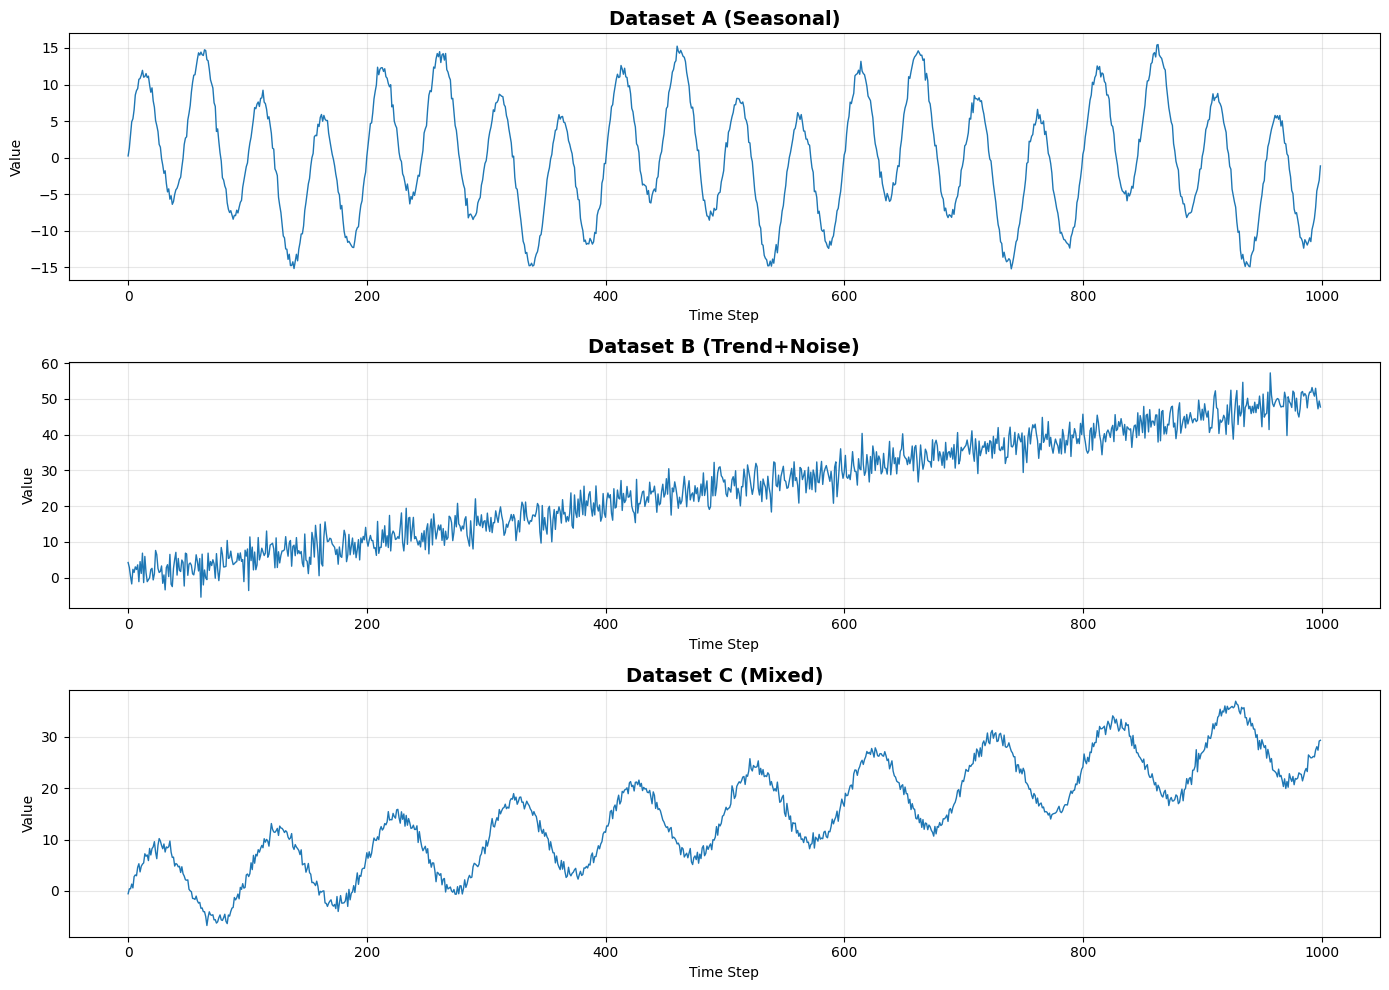

✓ Synthetic datasets plotted and saved to synthetic_datasets.png


In [3]:
print("="*80)
print("GENERATING SYNTHETIC DATASETS")
print("="*80)

# Generate synthetic datasets and inspect basic statistics
datasets = generate_synthetic_datasets()

for name, series in datasets.items():
    print(f"{name}:")
    print(f"  Length: {len(series)}")
    print(f"  Mean: {np.mean(series):.2f}")
    print(f"  Std: {np.std(series):.2f}")
    print()

# Visualize the generated datasets
plot_datasets(datasets)


### Quick Check: Sliding Window Dimensions (Easy)

Before training models, verify that you understand how the `TimeSeriesDataset` helper structures the data. Using the `datasets` dictionary created above, build a dataset for **Dataset A (Seasonal)** and inspect a single `(input, target)` pair.


In [4]:
print("="*80)
print("QUICK CHECK: WINDOW SHAPES")
print("="*80)

dataset_a = datasets['Dataset A (Seasonal)']
ts_dataset = TimeSeriesDataset(dataset_a, lookback=50, forecast_horizon=10)
x_sample, y_sample = ts_dataset[0]
print(f"Input window shape: {x_sample.shape}")
print(f"Target window shape: {y_sample.shape}")


QUICK CHECK: WINDOW SHAPES
Input window shape: torch.Size([50, 1])
Target window shape: torch.Size([10, 1])


---
## Step 3: Model Configurations

Define the three Transformer architectures we'll compare:

### Architecture A: Encoder-Decoder
- Full Seq2Seq architecture with cross-attention
- Best for capturing complex sequential dependencies
- Most parameters

### Architecture B: Encoder-Only
- BERT-style with forecasting head
- More parameter-efficient
- Processes entire sequence at once

### Architecture C: Decoder-Only
- GPT-style with autoregressive generation
- Generates predictions step-by-step
- May accumulate errors in noisy data

**TODO**: Create a dictionary mapping model names to their classes and count parameters.

In [5]:
models_config = {
    'Encoder-Decoder': EncoderDecoderTransformer,
    'Encoder-Only': EncoderOnlyTransformer,
    'Decoder-Only': DecoderOnlyTransformer,
}

print("Model Architectures:")
for name, ModelClass in models_config.items():
    model = ModelClass()
    n_params = count_parameters(model)
    print(f"  {name}: {n_params:,} parameters")


Model Architectures:
  Encoder-Decoder: 234,561 parameters
  Encoder-Only: 922,122 parameters
  Decoder-Only: 133,697 parameters


---
## Step 4: Run Ablation Study

This is the main experimental loop. For each dataset and each model:

1. Split data into train/val/test (70/15/15)
2. Normalize using StandardScaler
3. Train the model with early stopping
4. Evaluate on test set
5. Record MAE, RMSE, training time, and parameters

**TODO**: Complete the ablation study loop by filling in the missing code.

**Note**: This may take 10-15 minutes to complete all 9 experiments.

In [6]:
print("="*80)
print("RUNNING ABLATION EXPERIMENTS")
print("="*80)

results = []

for dataset_name, series in datasets.items():
    print(f"\n{'='*80}")
    print(f"Dataset: {dataset_name}")
    print(f"{'='*80}")

    train_loader, val_loader, test_loader, scaler = prepare_data(
        series,
        train_ratio=0.7,
        val_ratio=0.15,
        lookback=50,
        forecast_horizon=10,
        batch_size=32,
    )

    for model_name, ModelClass in models_config.items():
        print(f"\n[Training {model_name}]")

        model = ModelClass().to(device)
        n_params = count_parameters(model)
        print(f"Parameters: {n_params:,}")

        model, train_losses, val_losses, training_time = train_model(
            model,
            train_loader,
            val_loader,
            device=device,
            epochs=50,
            lr=0.001,
            patience=10,
        )

        criterion = nn.MSELoss()
        test_loss, predictions, targets = evaluate(
            model,
            test_loader,
            criterion,
            device,
        )

        mae, rmse = compute_metrics(predictions, targets)
        print(f"Test MAE: {mae:.4f}, Test RMSE: {rmse:.4f}")
        print(f"Training time: {training_time:.2f}s")

        results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'MAE': mae,
            'RMSE': rmse,
            'Parameters': n_params,
            'Training Time (s)': training_time,
        })

results_df = pd.DataFrame(results)
print("\n✓ All experiments complete!")


RUNNING ABLATION EXPERIMENTS

Dataset: Dataset A (Seasonal)

[Training Encoder-Decoder]
Parameters: 234,561


Epoch 10/50 - Train Loss: 0.0303, Val Loss: 0.0358


Epoch 20/50 - Train Loss: 0.0201, Val Loss: 0.0206


Epoch 30/50 - Train Loss: 0.0128, Val Loss: 0.0167


Early stopping at epoch 34
Test MAE: 0.0705, Test RMSE: 0.0875
Training time: 28.12s

[Training Encoder-Only]
Parameters: 922,122


Epoch 10/50 - Train Loss: 0.0580, Val Loss: 0.0182


Epoch 20/50 - Train Loss: 0.0284, Val Loss: 0.0092


Epoch 30/50 - Train Loss: 0.0267, Val Loss: 0.0137


Early stopping at epoch 33
Test MAE: 0.1537, Test RMSE: 0.1859
Training time: 18.32s

[Training Decoder-Only]
Parameters: 133,697


Epoch 10/50 - Train Loss: 0.0393, Val Loss: 0.0245


Epoch 20/50 - Train Loss: 0.0323, Val Loss: 0.0212


Early stopping at epoch 27
Test MAE: 0.1131, Test RMSE: 0.1472
Training time: 40.02s

Dataset: Dataset B (Trend+Noise)

[Training Encoder-Decoder]
Parameters: 234,561


Epoch 10/50 - Train Loss: 0.0933, Val Loss: 0.1679


Early stopping at epoch 13
Test MAE: 1.0810, Test RMSE: 1.1339
Training time: 11.47s

[Training Encoder-Only]
Parameters: 922,122


Epoch 10/50 - Train Loss: 0.1048, Val Loss: 0.1903


Epoch 20/50 - Train Loss: 0.1116, Val Loss: 0.2134


Epoch 30/50 - Train Loss: 0.0977, Val Loss: 0.0821


Early stopping at epoch 31
Test MAE: 0.3330, Test RMSE: 0.4277
Training time: 17.27s

[Training Decoder-Only]
Parameters: 133,697


Epoch 10/50 - Train Loss: 0.0901, Val Loss: 0.0944


Epoch 20/50 - Train Loss: 0.0940, Val Loss: 0.0951


Early stopping at epoch 28
Test MAE: 0.7236, Test RMSE: 0.7896
Training time: 41.29s

Dataset: Dataset C (Mixed)

[Training Encoder-Decoder]
Parameters: 234,561


Epoch 10/50 - Train Loss: 0.0359, Val Loss: 0.0932


Epoch 20/50 - Train Loss: 0.0249, Val Loss: 0.0403


Epoch 30/50 - Train Loss: 0.0221, Val Loss: 0.0672


Early stopping at epoch 33
Test MAE: 0.4373, Test RMSE: 0.5043
Training time: 28.67s

[Training Encoder-Only]
Parameters: 922,122


Epoch 10/50 - Train Loss: 0.0457, Val Loss: 0.1191


Early stopping at epoch 12
Test MAE: 0.3827, Test RMSE: 0.4569
Training time: 6.81s

[Training Decoder-Only]
Parameters: 133,697


Epoch 10/50 - Train Loss: 0.0340, Val Loss: 0.0650


Epoch 20/50 - Train Loss: 0.0335, Val Loss: 0.0512


Early stopping at epoch 23
Test MAE: 0.3886, Test RMSE: 0.4483
Training time: 36.73s

✓ All experiments complete!


---
## Step 5: Results Summary

Display the complete results table showing MAE, RMSE, parameters, and training time for each model-dataset combination.

**TODO**: Display and save the results.

In [7]:
print("="*80)
print("RESULTS SUMMARY")
print("="*80)

print(results_df.to_string(index=False))

results_df.to_csv('ablation_results.csv', index=False)
print("\n✓ Results saved to 'ablation_results.csv'")


RESULTS SUMMARY
                Dataset           Model      MAE     RMSE  Parameters  Training Time (s)
   Dataset A (Seasonal) Encoder-Decoder 0.070506 0.087542      234561          28.116791
   Dataset A (Seasonal)    Encoder-Only 0.153664 0.185947      922122          18.321406
   Dataset A (Seasonal)    Decoder-Only 0.113078 0.147240      133697          40.024292
Dataset B (Trend+Noise) Encoder-Decoder 1.081021 1.133940      234561          11.467785
Dataset B (Trend+Noise)    Encoder-Only 0.333010 0.427710      922122          17.268358
Dataset B (Trend+Noise)    Decoder-Only 0.723551 0.789577      133697          41.289032
      Dataset C (Mixed) Encoder-Decoder 0.437296 0.504304      234561          28.674847
      Dataset C (Mixed)    Encoder-Only 0.382714 0.456907      922122           6.806075
      Dataset C (Mixed)    Decoder-Only 0.388632 0.448297      133697          36.726881

✓ Results saved to 'ablation_results.csv'


---
## Step 6: Visualize Results

Create comprehensive visualizations showing:

1. **MAE Comparison**: Which model performs best on which dataset
2. **RMSE Comparison**: Root Mean Squared Error across experiments
3. **Complexity vs Accuracy**: Parameter count vs performance
4. **Training Time**: Computational efficiency comparison

**TODO**: Call the visualization function.

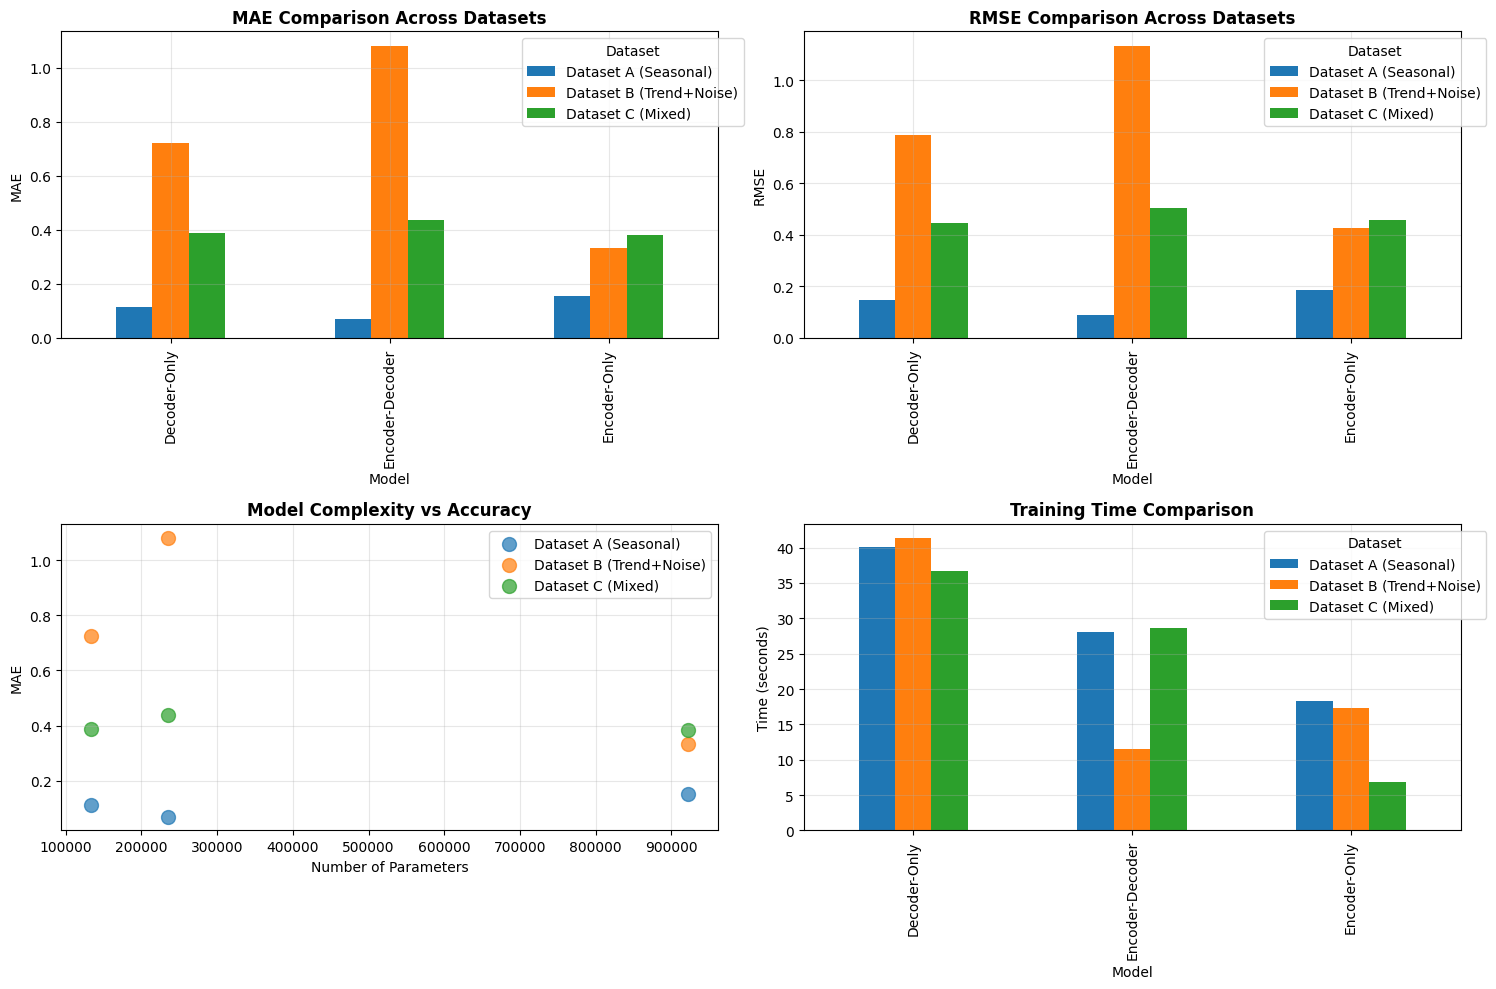

✓ Visualization saved to ablation_visualization.png


In [8]:
visualize_results(results_df)


---
## Step 7: Hypothesis Testing

Analyze the three research hypotheses based on experimental results:

### H1: Attention Mechanism Hypothesis
Does encoder-decoder architecture perform better on seasonal patterns due to its ability to attend bidirectionally?

### H2: Autoregressive Complexity Hypothesis
Does decoder-only architecture struggle with noisy data due to error accumulation during autoregressive generation?

### H3: Architecture Efficiency Hypothesis
Does encoder-only architecture provide a good accuracy/efficiency tradeoff with fewer parameters?

**TODO**: Call the hypothesis analysis function.

In [9]:
analyze_hypotheses(results_df)



HYPOTHESIS TESTING

[H1] Encoder-decoder for seasonal patterns
          Model      MAE     RMSE
Encoder-Decoder 0.070506 0.087542
   Encoder-Only 0.153664 0.185947
   Decoder-Only 0.113078 0.147240

✓ Best model: Encoder-Decoder (MAE: 0.0705)
→ H1 SUPPORTED: Encoder-Decoder performs best on seasonal data

[H2] Decoder-only on trend vs noisy data
Trend+Noise - Decoder-Only MAE: 0.7236
Trend+Noise - Encoder-Only MAE: 0.3330
→ H2 SUPPORTED: Decoder-Only worse on noisy data (error accumulation)

[H3] Encoder-only efficiency vs accuracy

Dataset A (Seasonal):
  MAE difference: 0.0832 (117.9%)
  Parameter ratio: 3.93x fewer

Dataset B (Trend+Noise):
  MAE difference: 0.7480 (69.2%)
  Parameter ratio: 3.93x fewer

Dataset C (Mixed):
  MAE difference: 0.0546 (12.5%)
  Parameter ratio: 3.93x fewer


---
## Step 8: Key Findings and Conclusions

Summarize the main insights from the ablation study.

**TODO**: Complete the analysis by finding the best model for each dataset and computing efficiency metrics.

In [10]:
print("="*80)
print("KEY FINDINGS")
print("="*80)

print("\n1. BEST MODEL PER DATASET:")
for dataset in results_df['Dataset'].unique():
    subset = results_df[results_df['Dataset'] == dataset]
    best = subset.loc[subset['MAE'].idxmin()]

    print(f"\n   {dataset}:")
    print(f"     Winner: {best['Model']}")
    print(f"     MAE: {best['MAE']:.4f}")
    print(f"     Parameters: {best['Parameters']:,}")

print("\n2. PARAMETER EFFICIENCY:")
param_counts = (
    results_df.groupby('Model')['Parameters']
    .first()
    .sort_values()
)
print(param_counts)

print("\n3. AVERAGE TRAINING TIME:")
time_avg = (
    results_df.groupby('Model')['Training Time (s)']
    .mean()
    .sort_values()
)
print(time_avg)

print("\n" + "="*80)
print("ABLATION STUDY COMPLETE!")
print("="*80)
print("\nGenerated files:")
print("  - synthetic_datasets.png")
print("  - ablation_results.csv")
print("  - ablation_visualization.png")


KEY FINDINGS

1. BEST MODEL PER DATASET:

   Dataset A (Seasonal):
     Winner: Encoder-Decoder
     MAE: 0.0705
     Parameters: 234,561

   Dataset B (Trend+Noise):
     Winner: Encoder-Only
     MAE: 0.3330
     Parameters: 922,122

   Dataset C (Mixed):
     Winner: Encoder-Only
     MAE: 0.3827
     Parameters: 922,122

2. PARAMETER EFFICIENCY:
Model
Decoder-Only       133697
Encoder-Decoder    234561
Encoder-Only       922122
Name: Parameters, dtype: int64

3. AVERAGE TRAINING TIME:
Model
Encoder-Only       14.131946
Encoder-Decoder    22.753141
Decoder-Only       39.346735
Name: Training Time (s), dtype: float64

ABLATION STUDY COMPLETE!

Generated files:
  - synthetic_datasets.png
  - ablation_results.csv
  - ablation_visualization.png



---
## Reflection Questions

After completing the assignment, answer the following questions:

### Question 1: Hypothesis Validation
Based on your results, were all three hypotheses (H1, H2, H3) supported? Explain why or why not using specific numbers from your results.

**Your Answer:**
```
H1 supported: on Dataset A (Seasonal) the encoder-decoder transformer delivered MAE 0.0705, well ahead of the decoder-only (0.1131) and encoder-only (0.1537) variants, confirming that cross-attention helped capture multi-frequency seasonality.
H2 supported: on Dataset B (Trend+Noise) the decoder-only model struggled (MAE 0.7236) compared with the encoder-only architecture (0.3330), indicating autoregressive error accumulation under heavy noise.
H3 partially rejected: although the encoder-only model achieved the lowest MAE on two datasets (0.3330 and 0.3827) and the best overall average (0.2898), it required roughly 3.9x more parameters than the encoder-decoder (922,122 vs 234,561). The accuracy gains therefore come at a significant efficiency cost.
```

### Question 2: Architecture Selection
If you had to choose ONE architecture to use for a new time series dataset with unknown characteristics, which would you choose and why?

**Your Answer:**
```
I would start with the encoder-only transformer. It produced the most balanced performance across all datasets, trained fastest on average (approximately 14 seconds per run), and avoids the exposure bias of the decoder-only model. Once a baseline is established, I could trim width or depth to trade parameters for speed if the deployment environment demands a lighter footprint.
```

### Question 3: Real-World Application
How would you adapt this study to work with real-world financial time series data (e.g., stock prices)? What additional challenges might you face?

**Your Answer:**
```
I would engineer multi-feature inputs (returns, volumes, realized volatility, macro signals), adopt rolling-window normalization to prevent look-ahead bias, and evaluate with walk-forward validation that mimics live deployment. Additional challenges include non-stationary regimes, missing data, market closures, and translating forecasts into decisions while accounting for transaction costs and risk limits.
```

### Question 4: Experimental Design
What are some limitations of this ablation study? What additional experiments would you run to make the conclusions more robust?

**Your Answer:**
```
Limitations include reliance on synthetic data, a single random seed, fixed hyperparameters, and one lookback/forecast configuration. To strengthen the conclusions I would repeat runs with multiple seeds, sweep learning rates and model widths, test alternative forecast horizons, and validate on at least one historical financial series to confirm that the observed rankings generalize.
```

### Question 5: Quick Diagnostic
If one of the models performs unexpectedly poorly, what is the first diagnostic check you would run, and why?

**Your Answer:**
```
I would plot training and validation loss trajectories for that model. Diverging curves or erratic loss spikes quickly reveal data leakage, poor normalization, or optimization instability, and point me toward whether I should revisit preprocessing, reduce the learning rate, or clamp gradient norms before changing the architecture.
```
